In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_dir='./train'
val_dir='./val'
test_dir='./test'

In [4]:
BATCH_SIZE=64
IMG_SIZE=(128,128)
train_ds=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
            shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
val_ds=tf.keras.preprocessing.image_dataset_from_directory(val_dir,
            shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
test_ds=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
            shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 4897 files belonging to 2 classes.
Found 864 files belonging to 2 classes.
Found 639 files belonging to 2 classes.


In [5]:
class_names=train_ds.class_names
print(class_names)

['0', '1']


(64, 128, 128, 3)
(64,)
tf.Tensor(
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0], shape=(64,), dtype=int32)


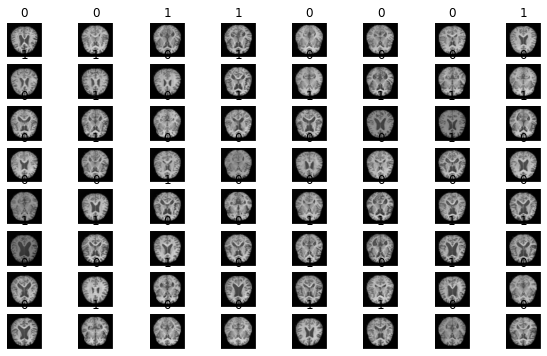

In [7]:
# a single batch
# visulize
plt.figure(figsize=(10,6))
for image_batch,label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch)
    for i in range(BATCH_SIZE):
        plt.subplot(8,8,i+1)
        plt.imshow(image_batch[i]/255.0) # float [0-1],int[0-255]
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

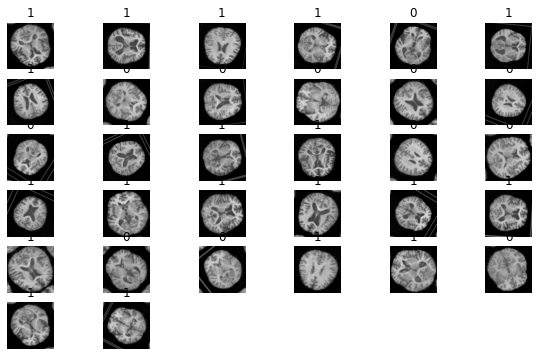

In [10]:
# Data augmentation 
data_aug=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    #tf.keras.layers.experimental.preprocessing.Randomcrop(100,100),
    # Random tranlate, random height, Random width
])
plt.figure(figsize=(10,6))
for image_batch,label_batch in train_ds.take(1):
    aug_img=data_aug(image_batch)
    for i in range(BATCH_SIZE):
        plt.subplot(6,6,i+1)
        plt.imshow(aug_img[i]/255.0) # float [0-1],int[0-255]
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [12]:
# manual scaling method ---[Not prefer in transfer learing]
scale_image=tf.keras.Sequential([
    tf.keras.layers.Resizing(128,128),
    tf.keras.layers.Rescaling(1.0/255)
])
for image_batch,label_batch in train_ds.take(1):
    aug_img=scale_image(image_batch)
print(aug_img.shape)

(32, 100, 100, 3)


In [33]:
################ most common in TL
######## preprocess input function
preprocess_inputs=tf.keras.applications.mobilenet_v2.preprocess_input
print(preprocess_inputs)
############# Load base model
# load a pretrained NN
base_model=tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                include_top=False,weights='imagenet')
base_model.trainable=False # freeze the model for training
print('Number of layers=',len(base_model.layers))
print('Number of weights[W/B]=',len(base_model.weights))
print('Number of trainable variables=',len(base_model.trainable_variables))
base_model.summary()
############

<function preprocess_input at 0x0000016FEF541AF0>
9420800/9406464 [==============================] - 140s 15us/step
Number of layers= 154
Number of weights[W/B]= 260
Number of trainable variables= 0
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_13[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]

In [34]:
# custom model
inputs=tf.keras.Input(shape=(160,160,3)) # input layer
#x=data_aug(inputs)                       # data augmentation
#x=scale_image(inputs)                       # data augmentation
x=preprocess_inputs(inputs)     #imagenetv2           # preprocessing as model 
x=base_model(x,training=False)           # base model
###############################################
x=tf.keras.layers.GlobalAveragePooling2D()(x) # Nonex1280
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(100)(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(50)(x)
outputs=tf.keras.layers.Dense(1)(x) # outer layer 1 neuron, 
model=tf.keras.Model(inputs,outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [37]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
hist=model.fit(train_ds,epochs=10,validation_data=val_ds)
loss1,acc1=model.evaluate(test_ds)
print('Training Accuracy after training=',acc1)

Epoch 1/10
154/154 [==============================] - 88s 552ms/step - loss: 7.6231 - accuracy: 0.5001 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/10
154/154 [==============================] - 86s 555ms/step - loss: 7.6231 - accuracy: 0.5001 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/10
154/154 [==============================] - 85s 552ms/step - loss: 7.6231 - accuracy: 0.5001 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/10
 45/154 [=======>......................] - ETA: 51s - loss: 7.6987 - accuracy: 0.4951

KeyboardInterrupt: 

In [9]:
IMG_HEIGHT=128
IMG_WIDTH=128
from tensorflow import keras
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                            input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(2,"softmax"))

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)       

In [12]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=100, batch_size=64, verbose=1)

Epoch 1/100
77/77 [==============================] - 68s 845ms/step - loss: 0.8730 - accuracy: 0.4970 - val_loss: 0.6927 - val_accuracy: 0.5810
Epoch 2/100
77/77 [==============================] - 65s 837ms/step - loss: 0.6915 - accuracy: 0.5322 - val_loss: 0.6904 - val_accuracy: 0.6655
Epoch 3/100
77/77 [==============================] - 66s 849ms/step - loss: 0.6886 - accuracy: 0.5332 - val_loss: 0.6858 - val_accuracy: 0.5961
Epoch 4/100
77/77 [==============================] - 86s 1s/step - loss: 0.6735 - accuracy: 0.5873 - val_loss: 0.6587 - val_accuracy: 0.6736
Epoch 5/100
77/77 [==============================] - 66s 844ms/step - loss: 0.6479 - accuracy: 0.6167 - val_loss: 0.6687 - val_accuracy: 0.6053
Epoch 6/100
77/77 [==============================] - 58s 745ms/step - loss: 0.6125 - accuracy: 0.6649 - val_loss: 0.6118 - val_accuracy: 0.6481
Epoch 7/100
77/77 [==============================] - 56s 729ms/step - loss: 0.5882 - accuracy: 0.6865 - val_loss: 0.6082 - val_accuracy: 0.

In [50]:
loss, accuracy = model.evaluate(test_ds)

10/10 [==============================] - 2s 197ms/step - loss: 0.0162 - accuracy: 0.9937


In [51]:
accuracy

0.9937402009963989

In [16]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

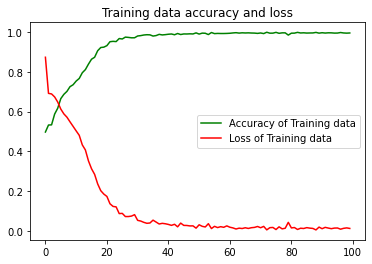

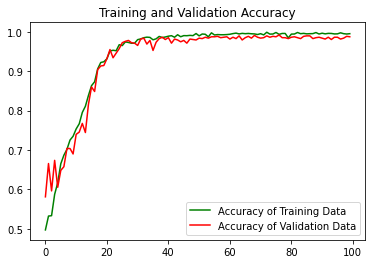

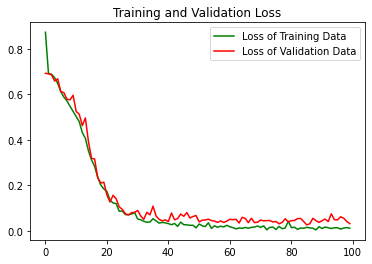

<Figure size 432x288 with 0 Axes>

In [17]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [60]:
y_pred=model.predict(test_ds)
y_pred

array([[8.2896503e-07, 9.9999917e-01],
       [2.4252534e-03, 9.9757475e-01],
       [4.4333045e-03, 9.9556667e-01],
       ...,
       [1.0000000e+00, 4.4172999e-08],
       [9.4789082e-01, 5.2109141e-02],
       [9.9839419e-01, 1.6058268e-03]], dtype=float32)

In [61]:
score=tf.nn.softmax(y_pred)
score

<tf.Tensor: shape=(639, 2), dtype=float32, numpy=
array([[0.26894173, 0.73105824],
       [0.26989615, 0.7301038 ],
       [0.2706883 , 0.72931176],
       ...,
       [0.7310586 , 0.26894143],
       [0.7100819 , 0.28991815],
       [0.7304266 , 0.26957333]], dtype=float32)>

In [64]:
y_p=np.argmax(score,axis=1)
y_p

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,

In [79]:

final_y_pred=class_names[y_p[1]]  
final_y_pred

'1'

In [68]:
class_names

['0', '1']

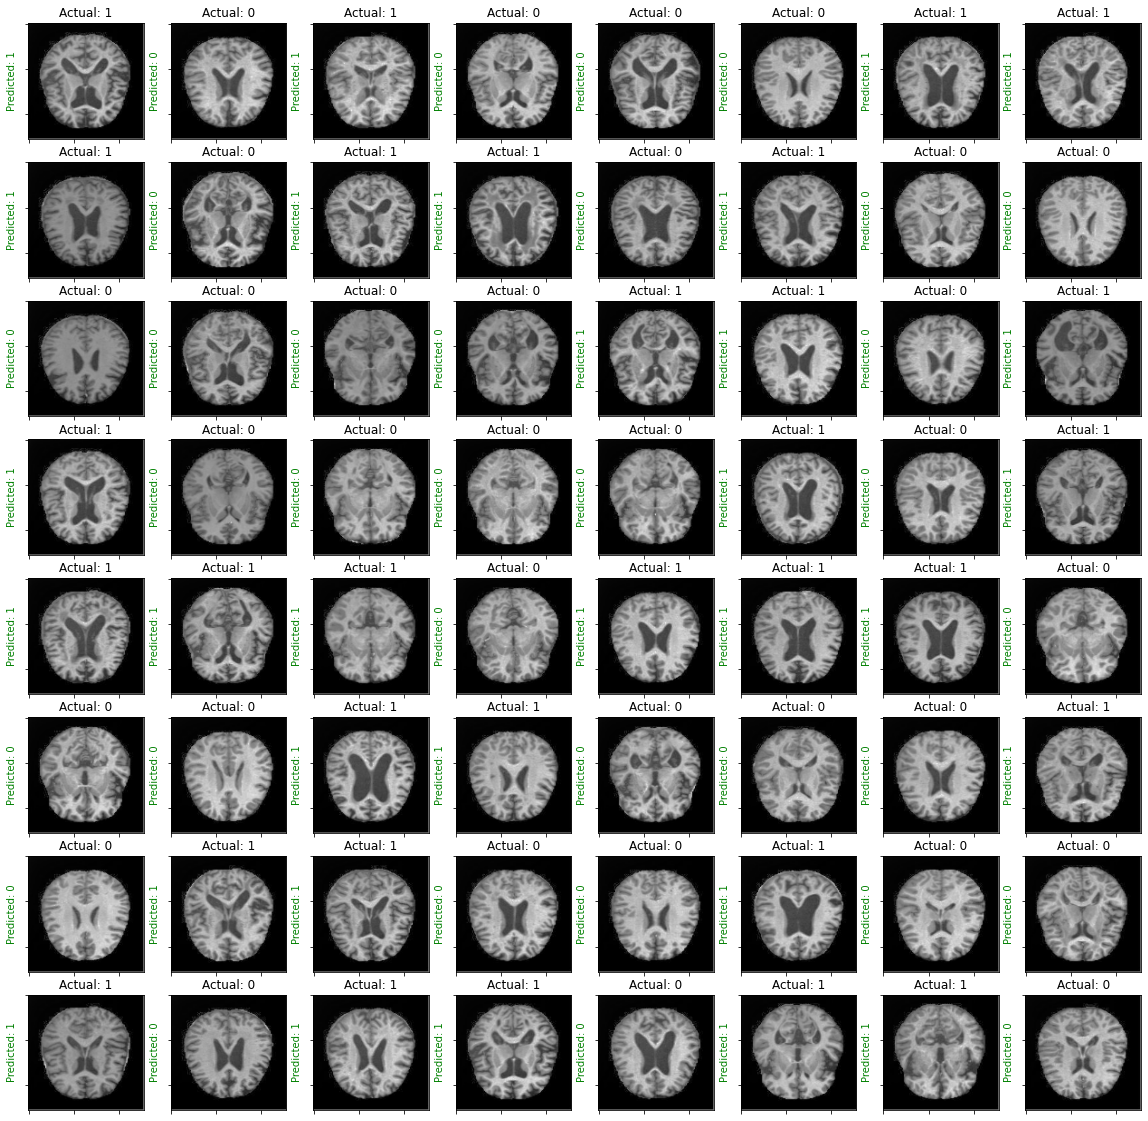

In [80]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(64):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

In [81]:
#plt.figure(figsize=(20, 20))
p=[]
t=[]
for images, labels in test_ds.take(1):
    for i in range(64):
        #ax = plt.subplot(8, 8, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        p.append(np.argmax(score))
        t.append(labels[i])

In [88]:
#plt.figure(figsize=(20, 20))
p=[]
t=[]
for images, labels in test_ds:
    
        #ax = plt.subplot(8, 8, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(images)
        score = np.argmax(tf.nn.softmax(predictions),axis=1)
        p.append(score)
        t.append(labels)

In [89]:
p1=np.concatenate(p)
t1=np.concatenate(t)

In [111]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(t1,p1)
cm

array([[319,   1],
       [  3, 316]], dtype=int64)

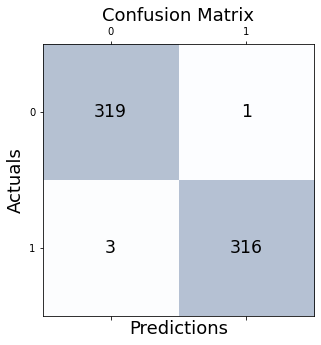

In [112]:
conf_matrix=cm
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [93]:
z=(p1!=t1).sum()
z

4

In [97]:
p1!=t1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [98]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


In [113]:
#plt.figure(figsize=(20, 20))
p_train=[]
t_train=[]
for images, labels in train_ds:
    
        #ax = plt.subplot(8, 8, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(images)
        score = np.argmax(tf.nn.softmax(predictions),axis=1)
        p_train.append(score)
        t_train.append(labels)

In [118]:
#plt.figure(figsize=(20, 20))
p_val=[]
t_val=[]
for images, labels in val_ds:
    
        #ax = plt.subplot(8, 8, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(images)
        score = np.argmax(tf.nn.softmax(predictions),axis=1)
        p_val.append(score)
        t_val.append(labels)

In [119]:
p_train1=np.concatenate(p_train)
t_train1=np.concatenate(t_train)
p_val1=np.concatenate(p_val)
t_val1=np.concatenate(t_val)

In [120]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(t_train1,p_train1)
cm

array([[2448,    0],
       [   0, 2449]], dtype=int64)

In [121]:
cm=confusion_matrix(t_val1,p_val1)
cm

array([[428,   4],
       [  7, 425]], dtype=int64)

In [122]:
import pickle
f=open('abc_l1.pck','wb')
pickle.dump(get_ac,f)
pickle.dump(get_los,f)
pickle.dump(val_acc,f)
pickle.dump(val_loss,f)
f.close()